In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import numpy as np
import os
from tqdm import tqdm
from pytorch_fid import fid_score
import matplotlib.pyplot as plt
import math
import kagglehub


In [31]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

# Hyperparameters
IMG_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 64
T = 700  # Number of diffusion steps
LR = 0.0001
EPOCHS = 450
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

> SelfAttention Module
The SelfAttention class implements spatial self-attention to allow the network to focus on important regions in the feature map, helping capture long-range dependencies in images.

It uses three convolutional layers to project the input into:

query: captures what to attend to.

key: represents what is being attended.

value: contains the actual information to aggregate.

The attention map is computed via the dot-product of query and key, followed by a softmax for normalization. This tells the network how much attention to give each spatial location.

The value features are weighted by this attention map using batch matrix multiplication, then reshaped back into the original feature map shape.

A learnable parameter gamma (initialized to 0) allows the network to decide how much of the attention-modified output to use versus the original input (residual connection).
The SelfAttention block contains:

3 convolutional layers (query, key, value)

Query & Key: each maps C → C//8 channels using a 1×1 conv

Value: keeps original C channels

1 learnable parameter: gamma (scalar)

Uses softmax for attention weighting and torch.bmm for batched matrix multiplication\

> UNet Architecture (with Time Embedding + Attention)
The UNet class defines a U-Net style architecture with skip connections, commonly used in generative models, especially for image-to-image tasks.

It has a symmetric encoder-decoder structure:

Encoder progressively downsamples the image and extracts higher-level features.

Decoder upsamples the features and reconstructs the output, with skip connections that concatenate features from the encoder at each level.

Each encoder/decoder block uses a custom conv_block, which applies two convolutional layers followed by batch normalization and ReLU activation.

Self-attention is added at the bottleneck (deepest point) to enhance global spatial understanding.

Time embedding is incorporated using a small feedforward neural network. This encodes the current timestep (from the diffusion process) into a vector that’s added to the bottleneck features, enabling time-dependent generation.

Max pooling is used for downsampling in the encoder.

Upsampling is done using interpolate (bilinear mode) to increase spatial resolution in the decoder, followed by concatenation with corresponding encoder features.

The final output is generated using a 1x1 convolution to project the decoded features back to the desired number of output channels.

The U-Net in your code is composed of:

🔹 Encoder (Downsampling path)
encoder1: input (3 → 64)

2 conv layers (3→64, then 64→64)

encoder2: 64 → 128

2 conv layers (64→128, 128→128)

encoder3: 128 → 256

2 conv layers (128→256, 256→256)

encoder4: 256 → 512

2 conv layers (256→512, 512→512)

✅ Total encoder layers = 8 convolutional layers

🔹 Bottleneck
A conv_block: 512 → 1024 (2 conv layers: 512→1024, 1024→1024)

Followed by a SelfAttention block (described above)

✅ Bottleneck = 2 conv layers + attention module

🔹 Decoder (Upsampling path with skip connections)
decoder4: (1024 + 512) → 512

2 conv layers: 1536→512, 512→512

decoder3: (512 + 256) → 256

2 conv layers: 768→256, 256→256

decoder2: (256 + 128) → 128

2 conv layers: 384→128, 128→128

decoder1: (128 + 64) → 64

2 conv layers: 192→64, 64→64

✅ Total decoder layers = 8 convolutional layers

🔹 Final layer
A 1×1 conv layer mapping 64 → 3 channels

✅ Final = 1 convolutional layer

🔹 Time Embedding
2 Linear layers: 1 → 512, then 512 → 512 (used for timestep embedding)




In [32]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        batch_size, C, H, W = x.size()
        query = self.query(x).view(batch_size, -1, H * W).permute(0, 2, 1)  # (B, H*W, C//8)
        key = self.key(x).view(batch_size, -1, H * W)  # (B, C//8, H*W)
        attention = self.softmax(torch.bmm(query, key))  # (B, H*W, H*W)
        value = self.value(x).view(batch_size, -1, H * W)  # (B, C, H*W)

        out = torch.bmm(value, attention.permute(0, 2, 1))  # (B, C, H*W)
        out = out.view(batch_size, C, H, W)
        out = self.gamma * out + x
        return out

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, base_channels=64):
        super(UNet, self).__init__()
        self.encoder1 = self.conv_block(in_channels, base_channels)
        self.encoder2 = self.conv_block(base_channels, base_channels * 2)
        self.encoder3 = self.conv_block(base_channels * 2, base_channels * 4)
        self.encoder4 = self.conv_block(base_channels * 4, base_channels * 8)

        # Bottleneck with self-attention
        self.bottleneck = nn.Sequential(
            self.conv_block(base_channels * 8, base_channels * 16),
            SelfAttention(base_channels * 16)
        )

        # Adjust input channels for decoder blocks
        self.decoder4 = self.conv_block(base_channels * 16 + base_channels * 8, base_channels * 8)
        self.decoder3 = self.conv_block(base_channels * 8 + base_channels * 4, base_channels * 4)
        self.decoder2 = self.conv_block(base_channels * 4 + base_channels * 2, base_channels * 2)
        self.decoder1 = self.conv_block(base_channels * 2 + base_channels, base_channels)

        self.final = nn.Conv2d(base_channels, out_channels, kernel_size=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Positional embedding for timesteps
        self.time_embedding = nn.Sequential(
            nn.Linear(1, base_channels * 8),
            nn.ReLU(),
            nn.Linear(base_channels * 8, base_channels * 8)
        )

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, t):
        # Encode timesteps into a positional embedding
        t = t.view(-1, 1).float()  # Ensure t has shape (batch_size, 1)
        t_emb = self.time_embedding(t).view(t.size(0), -1, 1, 1)  # Reshape to (batch_size, channels, 1, 1)

        # Encoder
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))

        # Add timestep embedding to the bottleneck input
        bottleneck = self.bottleneck(self.pool(enc4) + t_emb)

        # Decoder
        dec4 = self.decoder4(torch.cat([enc4, nn.functional.interpolate(bottleneck, scale_factor=2, mode='bilinear', align_corners=False)], dim=1))
        dec3 = self.decoder3(torch.cat([enc3, nn.functional.interpolate(dec4, scale_factor=2, mode='bilinear', align_corners=False)], dim=1))
        dec2 = self.decoder2(torch.cat([enc2, nn.functional.interpolate(dec3, scale_factor=2, mode='bilinear', align_corners=False)], dim=1))
        dec1 = self.decoder1(torch.cat([enc1, nn.functional.interpolate(dec2, scale_factor=2, mode='bilinear', align_corners=False)], dim=1))

        return self.final(dec1)

> Diffusion Class — Overview
This class defines the core diffusion process used in generative models like DDPMs, handling both noise addition (forward) and denoising (reverse) steps.

> Initialization (__init__)
Takes T: total diffusion steps.

Uses a cosine noise schedule for smoother noise progression.

Computes:

betas: noise at each step.

alphas: retained signal (1 - beta).

alpha_bars: cumulative product of alphas.

Precomputes √alpha_bar and √(1 - alpha_bar) for efficiency.

Moves tensors to device.

> _cosine_variance_schedule(T)
Implements the cosine-based schedule from [Nichol & Dhariwal, 2021].

Returns betas clipped between 0 and 0.999 to ensure stability.

> forward_process(x0, t)
Simulates adding noise at timestep t.

Computes:
x_t = √(alphāₜ) * x₀ + √(1 - alphāₜ) * ε

Returns the noisy image x_t and the noise ε.

> sample_timesteps(n)
Samples n random timesteps from 1 to T (used during training).

> reverse_process(model, n, img_size)
Starts from pure noise → iteratively denoises to generate image.

For each timestep t:

Predict noise using the model.

Estimate x₀, optionally clamp it.

Compute mean & variance, update x.

Returns the final predicted x₀ (denoised image).

This class powers both training (adding noise) and inference (generating from noise), and supports modern DDPM-style generation with efficient cosine scheduling.


In [33]:
class Diffusion:
    def __init__(self, T):
        self.T = T
        
        # Cosine noise schedule
        self.betas = self._cosine_variance_schedule(T)
        self.alphas = 1. - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_bars = torch.sqrt(self.alpha_bars).to(device)
        self.sqrt_one_minus_alpha_bars = torch.sqrt(1. - self.alpha_bars).to(device)
        
    def _cosine_variance_schedule(self, T, s=0.008):
        """Cosine noise schedule as proposed in https://arxiv.org/abs/2102.09672"""
        steps = T + 1
        x = torch.linspace(0, T, steps)
        alphas_cumprod = torch.cos(((x / T) + s) / (1 + s) * math.pi * 0.5) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        return torch.clip(betas, 0, 0.999)
    
    def forward_process(self, x0, t):
        """Apply noise to x0 at time t"""
        noise = torch.randn_like(x0)
        sqrt_alpha_bar_t = self.sqrt_alpha_bars[t].view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_bar_t = self.sqrt_one_minus_alpha_bars[t].view(-1, 1, 1, 1)
        xt = sqrt_alpha_bar_t * x0 + sqrt_one_minus_alpha_bar_t * noise
        return xt, noise
    
    def sample_timesteps(self, n):
        """Sample random timesteps"""
        return torch.randint(low=1, high=self.T, size=(n,)).to(device)
    
    def reverse_process(self, model, n, img_size, clip_denoised=True):
        """Generate samples from noise"""
        model.eval()
        with torch.no_grad():
            # Start from pure noise
            x = torch.randn((n, CHANNELS, img_size, img_size)).to(device)
            
            for t in range(self.T, 0, -1):
                t_tensor = torch.full((n,), t, device=device)
                predicted_noise = model(x, t_tensor)
                
                alpha_t = self.alphas[t-1]
                alpha_bar_t = self.alpha_bars[t-1]
                beta_t = self.betas[t-1]
                
                if t > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                
                # Different parameterization compared to linear schedule
                pred_x0 = (x - torch.sqrt(1 - alpha_bar_t) * predicted_noise) / torch.sqrt(alpha_bar_t)
                if clip_denoised:
                    pred_x0 = torch.clamp(pred_x0, -1., 1.0)
                
                # Calculate mean and variance
                mean = (x - (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t) * predicted_noise) / torch.sqrt(alpha_t)
                variance = beta_t
                
                x = mean + torch.sqrt(variance) * noise
                
        model.train()
        return pred_x0  # Return the predicted x0 instead of the noisy x

In [34]:
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")
# Load CelebA dataset
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

dataset = datasets.ImageFolder(root= path, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)


In [35]:
# Function to calculate FID
def calculate_fid(real_images, fake_images):
    # Save real and fake images to temporary directories
    real_dir = "temp_real"
    fake_dir = "temp_fake"
    os.makedirs(real_dir, exist_ok=True)
    os.makedirs(fake_dir, exist_ok=True)

    # Save real images
    for i, img in enumerate(real_images):
        save_image(img * 0.5 + 0.5, os.path.join(real_dir, f"real_{i}.png"), normalize=True)

    # Save fake images
    for i, img in enumerate(fake_images):
        save_image(img * 0.5 + 0.5, os.path.join(fake_dir, f"fake_{i}.png"), normalize=True)

    # Calculate FID
    fid_value = fid_score.calculate_fid_given_paths([real_dir, fake_dir], 
                                                  batch_size=BATCH_SIZE, 
                                                  device=device, 
                                                  dims=2048)

    # Clean up temporary directories
    for img_file in os.listdir(real_dir):
        os.remove(os.path.join(real_dir, img_file))
    for img_file in os.listdir(fake_dir):
        os.remove(os.path.join(fake_dir, img_file))
    os.rmdir(real_dir)
    os.rmdir(fake_dir)

    return fid_value

Model Initialization and Training Setup
Model: A UNet architecture is initialized and moved to the specified device (CPU/GPU).

Diffusion Process: A Diffusion instance is created with T timesteps for noise scheduling.

Optimizer: Uses AdamW optimizer for model parameters, with a learning rate of LR.

Learning Rate Scheduler: Employs CosineAnnealingLR to adjust the learning rate dynamically during training.

> Training Loop
Epochs: Loop runs for EPOCHS iterations to train the model.

Batch Processing:

Real Images: A batch of images is taken from the dataloader.

Timestep Sampling: Random timesteps t are sampled for each batch.

Noise Addition (Forward Process): Noise is added to real images according to the diffusion process.

Noise Prediction: The model predicts the added noise for the noisy images.

Loss Calculation: The loss is computed as a combination of Mean Squared Error (MSE) and L1 loss.

Backpropagation:

Gradients are computed and the optimizer updates the model weights.

Learning Rate Update: The learning rate scheduler adjusts the learning rate after every epoch.

> FID and Generated Samples
FID Calculation:

Every 15 epochs, the model generates fake images from random noise using the reverse diffusion process.

A batch of real images is selected, and the FID score is calculated between real and generated images.

The FID score and generated samples are logged.

Display Samples: A batch of generated images is visualized using the show_tensor_images function, displaying 25 images at a time.

> Loss and FID Plotting
Loss & FID Plot: After every 15 epochs, a plot of the training loss and FID score is saved as training_loss_and_fid.png.

> Final Generated Samples
After training, the model generates final samples (25 images) and displays them for visual inspection.

This code structure allows for monitoring training progress via loss and FID scores and provides visual feedback through sample images.

100%|██████████| 3166/3166 [08:20<00:00,  6.33it/s]


Epoch [1/450] Loss: 0.1019 LR: 0.000100


100%|██████████| 3166/3166 [08:22<00:00,  6.31it/s]


Epoch [2/450] Loss: 0.0650 LR: 0.000100


100%|██████████| 3166/3166 [08:18<00:00,  6.35it/s]


Epoch [3/450] Loss: 0.0590 LR: 0.000100


100%|██████████| 3166/3166 [08:21<00:00,  6.32it/s]


Epoch [4/450] Loss: 0.0563 LR: 0.000100


100%|██████████| 3166/3166 [08:20<00:00,  6.32it/s]


Epoch [5/450] Loss: 0.0541 LR: 0.000100


100%|██████████| 3166/3166 [08:22<00:00,  6.30it/s]


Epoch [6/450] Loss: 0.0534 LR: 0.000100


100%|██████████| 3166/3166 [08:12<00:00,  6.42it/s]


Epoch [7/450] Loss: 0.0524 LR: 0.000100


100%|██████████| 3166/3166 [08:19<00:00,  6.34it/s]


Epoch [8/450] Loss: 0.0518 LR: 0.000100


100%|██████████| 3166/3166 [08:20<00:00,  6.32it/s]


Epoch [9/450] Loss: 0.0511 LR: 0.000100


100%|██████████| 3166/3166 [07:55<00:00,  6.66it/s]


Epoch [10/450] Loss: 0.0503 LR: 0.000100


100%|██████████| 3166/3166 [08:06<00:00,  6.50it/s]


Epoch [11/450] Loss: 0.0502 LR: 0.000100


100%|██████████| 3166/3166 [07:13<00:00,  7.31it/s]


Epoch [12/450] Loss: 0.0496 LR: 0.000100


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [13/450] Loss: 0.0491 LR: 0.000100


100%|██████████| 3166/3166 [07:13<00:00,  7.30it/s]


Epoch [14/450] Loss: 0.0490 LR: 0.000100


100%|██████████| 3166/3166 [07:16<00:00,  7.25it/s]


Epoch [15/450] Loss: 0.0492 LR: 0.000100


100%|██████████| 16/16 [00:07<00:00,  2.12it/s]


FID at epoch 15: 369.2368

Generated samples at epoch 15:


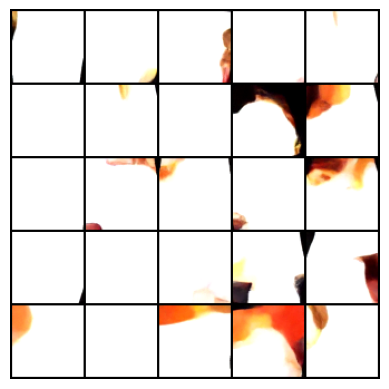

100%|██████████| 3166/3166 [07:20<00:00,  7.19it/s]


Epoch [16/450] Loss: 0.0487 LR: 0.000100


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [17/450] Loss: 0.0483 LR: 0.000100


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [18/450] Loss: 0.0480 LR: 0.000100


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [19/450] Loss: 0.0482 LR: 0.000100


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [20/450] Loss: 0.0479 LR: 0.000100


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [21/450] Loss: 0.0478 LR: 0.000099


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [22/450] Loss: 0.0481 LR: 0.000099


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [23/450] Loss: 0.0475 LR: 0.000099


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [24/450] Loss: 0.0474 LR: 0.000099


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [25/450] Loss: 0.0473 LR: 0.000099


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [26/450] Loss: 0.0474 LR: 0.000099


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [27/450] Loss: 0.0474 LR: 0.000099


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [28/450] Loss: 0.0471 LR: 0.000099


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [29/450] Loss: 0.0470 LR: 0.000099


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [30/450] Loss: 0.0471 LR: 0.000099


100%|██████████| 16/16 [00:06<00:00,  2.49it/s]


FID at epoch 30: 132.0581

Generated samples at epoch 30:


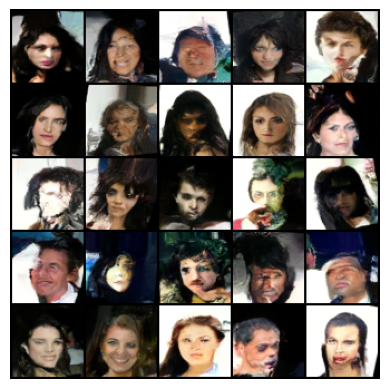

100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [31/450] Loss: 0.0469 LR: 0.000099


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [32/450] Loss: 0.0466 LR: 0.000099


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [33/450] Loss: 0.0466 LR: 0.000099


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [34/450] Loss: 0.0464 LR: 0.000099


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [35/450] Loss: 0.0464 LR: 0.000099


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [36/450] Loss: 0.0466 LR: 0.000098


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [37/450] Loss: 0.0465 LR: 0.000098


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [38/450] Loss: 0.0462 LR: 0.000098


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [39/450] Loss: 0.0465 LR: 0.000098


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [40/450] Loss: 0.0460 LR: 0.000098


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [41/450] Loss: 0.0465 LR: 0.000098


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [42/450] Loss: 0.0465 LR: 0.000098


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [43/450] Loss: 0.0462 LR: 0.000098


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [44/450] Loss: 0.0459 LR: 0.000098


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [45/450] Loss: 0.0462 LR: 0.000098


100%|██████████| 16/16 [00:06<00:00,  2.67it/s]


FID at epoch 45: 297.1990

Generated samples at epoch 45:


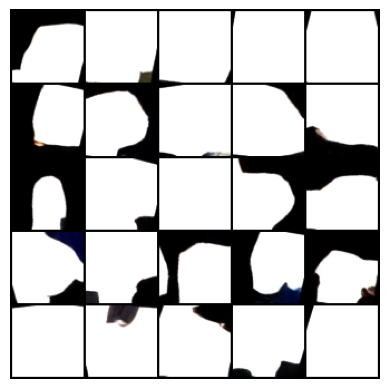

100%|██████████| 3166/3166 [07:16<00:00,  7.25it/s]


Epoch [46/450] Loss: 0.0458 LR: 0.000097


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [47/450] Loss: 0.0458 LR: 0.000097


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [48/450] Loss: 0.0458 LR: 0.000097


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [49/450] Loss: 0.0457 LR: 0.000097


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [50/450] Loss: 0.0459 LR: 0.000097


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [51/450] Loss: 0.0456 LR: 0.000097


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [52/450] Loss: 0.0458 LR: 0.000097


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [53/450] Loss: 0.0456 LR: 0.000097


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [54/450] Loss: 0.0458 LR: 0.000097


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [55/450] Loss: 0.0455 LR: 0.000096


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [56/450] Loss: 0.0459 LR: 0.000096


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [57/450] Loss: 0.0454 LR: 0.000096


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [58/450] Loss: 0.0457 LR: 0.000096


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [59/450] Loss: 0.0455 LR: 0.000096


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [60/450] Loss: 0.0455 LR: 0.000096


100%|██████████| 16/16 [00:06<00:00,  2.49it/s]


FID at epoch 60: 201.8444

Generated samples at epoch 60:


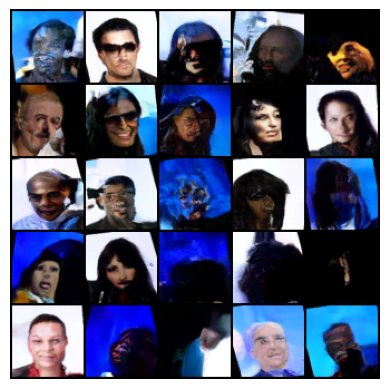

100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [61/450] Loss: 0.0453 LR: 0.000096


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [62/450] Loss: 0.0453 LR: 0.000095


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [63/450] Loss: 0.0454 LR: 0.000095


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [64/450] Loss: 0.0452 LR: 0.000095


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [65/450] Loss: 0.0454 LR: 0.000095


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [66/450] Loss: 0.0452 LR: 0.000095


100%|██████████| 3166/3166 [07:16<00:00,  7.25it/s]


Epoch [67/450] Loss: 0.0451 LR: 0.000095


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [68/450] Loss: 0.0451 LR: 0.000095


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [69/450] Loss: 0.0450 LR: 0.000094


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [70/450] Loss: 0.0451 LR: 0.000094


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [71/450] Loss: 0.0450 LR: 0.000094


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [72/450] Loss: 0.0452 LR: 0.000094


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [73/450] Loss: 0.0450 LR: 0.000094


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [74/450] Loss: 0.0449 LR: 0.000094


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [75/450] Loss: 0.0450 LR: 0.000093


100%|██████████| 16/16 [00:06<00:00,  2.53it/s]


FID at epoch 75: 264.5640

Generated samples at epoch 75:


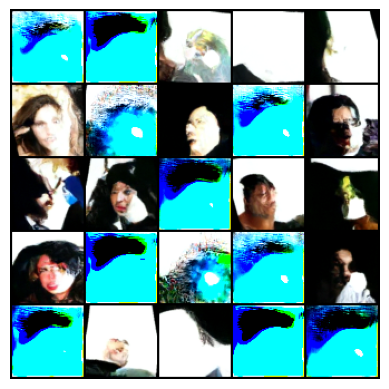

100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [76/450] Loss: 0.0451 LR: 0.000093


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [77/450] Loss: 0.0452 LR: 0.000093


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [78/450] Loss: 0.0452 LR: 0.000093


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [79/450] Loss: 0.0450 LR: 0.000093


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [80/450] Loss: 0.0451 LR: 0.000092


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [81/450] Loss: 0.0454 LR: 0.000092


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [82/450] Loss: 0.0449 LR: 0.000092


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [83/450] Loss: 0.0450 LR: 0.000092


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [84/450] Loss: 0.0449 LR: 0.000092


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [85/450] Loss: 0.0448 LR: 0.000092


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [86/450] Loss: 0.0448 LR: 0.000091


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [87/450] Loss: 0.0449 LR: 0.000091


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [88/450] Loss: 0.0449 LR: 0.000091


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [89/450] Loss: 0.0449 LR: 0.000091


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [90/450] Loss: 0.0448 LR: 0.000091


100%|██████████| 16/16 [00:06<00:00,  2.54it/s]


FID at epoch 90: 339.0338

Generated samples at epoch 90:


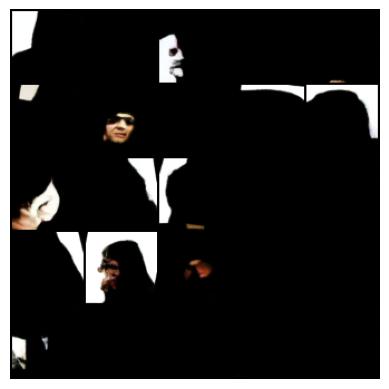

100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [91/450] Loss: 0.0448 LR: 0.000090


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [92/450] Loss: 0.0446 LR: 0.000090


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [93/450] Loss: 0.0446 LR: 0.000090


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [94/450] Loss: 0.0450 LR: 0.000090


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [95/450] Loss: 0.0449 LR: 0.000090


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [96/450] Loss: 0.0446 LR: 0.000089


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [97/450] Loss: 0.0446 LR: 0.000089


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [98/450] Loss: 0.0445 LR: 0.000089


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [99/450] Loss: 0.0445 LR: 0.000089


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [100/450] Loss: 0.0446 LR: 0.000088


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [101/450] Loss: 0.0446 LR: 0.000088


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [102/450] Loss: 0.0446 LR: 0.000088


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [103/450] Loss: 0.0448 LR: 0.000088


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [104/450] Loss: 0.0449 LR: 0.000088


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [105/450] Loss: 0.0445 LR: 0.000087


100%|██████████| 16/16 [00:06<00:00,  2.53it/s]


FID at epoch 105: 283.9371

Generated samples at epoch 105:


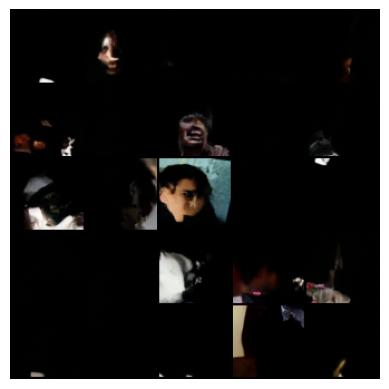

100%|██████████| 3166/3166 [07:16<00:00,  7.25it/s]


Epoch [106/450] Loss: 0.0446 LR: 0.000087


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [107/450] Loss: 0.0445 LR: 0.000087


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [108/450] Loss: 0.0446 LR: 0.000087


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [109/450] Loss: 0.0444 LR: 0.000086


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [110/450] Loss: 0.0448 LR: 0.000086


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [111/450] Loss: 0.0444 LR: 0.000086


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [112/450] Loss: 0.0441 LR: 0.000086


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [113/450] Loss: 0.0442 LR: 0.000085


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [114/450] Loss: 0.0445 LR: 0.000085


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [115/450] Loss: 0.0446 LR: 0.000085


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [116/450] Loss: 0.0446 LR: 0.000085


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [117/450] Loss: 0.0443 LR: 0.000084


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [118/450] Loss: 0.0446 LR: 0.000084


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [119/450] Loss: 0.0444 LR: 0.000084


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [120/450] Loss: 0.0444 LR: 0.000084


100%|██████████| 16/16 [00:06<00:00,  2.61it/s]


FID at epoch 120: 160.4526

Generated samples at epoch 120:


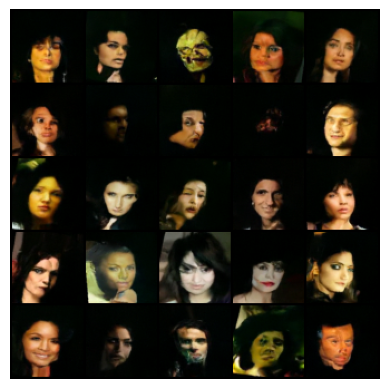

100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [121/450] Loss: 0.0444 LR: 0.000083


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [122/450] Loss: 0.0447 LR: 0.000083


100%|██████████| 3166/3166 [07:16<00:00,  7.25it/s]


Epoch [123/450] Loss: 0.0445 LR: 0.000083


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [124/450] Loss: 0.0443 LR: 0.000083


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [125/450] Loss: 0.0444 LR: 0.000082


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [126/450] Loss: 0.0444 LR: 0.000082


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [127/450] Loss: 0.0442 LR: 0.000082


100%|██████████| 3166/3166 [07:16<00:00,  7.25it/s]


Epoch [128/450] Loss: 0.0443 LR: 0.000082


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [129/450] Loss: 0.0441 LR: 0.000081


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [130/450] Loss: 0.0444 LR: 0.000081


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [131/450] Loss: 0.0439 LR: 0.000081


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [132/450] Loss: 0.0443 LR: 0.000080


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [133/450] Loss: 0.0442 LR: 0.000080


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [134/450] Loss: 0.0442 LR: 0.000080


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [135/450] Loss: 0.0442 LR: 0.000080


100%|██████████| 16/16 [00:06<00:00,  2.53it/s]


FID at epoch 135: 339.9622

Generated samples at epoch 135:


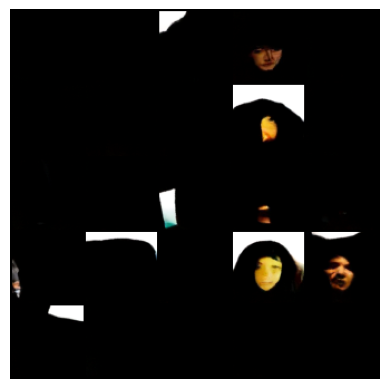

100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [136/450] Loss: 0.0442 LR: 0.000079


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [137/450] Loss: 0.0445 LR: 0.000079


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [138/450] Loss: 0.0445 LR: 0.000079


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [139/450] Loss: 0.0440 LR: 0.000078


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [140/450] Loss: 0.0440 LR: 0.000078


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [141/450] Loss: 0.0441 LR: 0.000078


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [142/450] Loss: 0.0444 LR: 0.000078


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [143/450] Loss: 0.0441 LR: 0.000077


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [144/450] Loss: 0.0442 LR: 0.000077


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [145/450] Loss: 0.0440 LR: 0.000077


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [146/450] Loss: 0.0441 LR: 0.000076


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [147/450] Loss: 0.0442 LR: 0.000076


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [148/450] Loss: 0.0445 LR: 0.000076


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [149/450] Loss: 0.0442 LR: 0.000076


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [150/450] Loss: 0.0439 LR: 0.000075


100%|██████████| 16/16 [00:06<00:00,  2.51it/s]


FID at epoch 150: 149.2033

Generated samples at epoch 150:


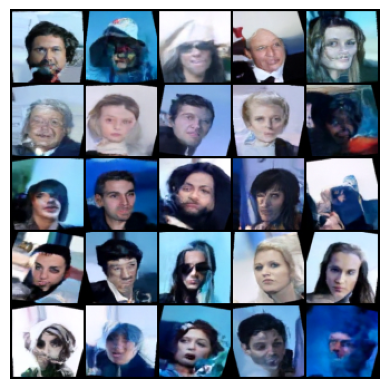

100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [151/450] Loss: 0.0442 LR: 0.000075


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [152/450] Loss: 0.0442 LR: 0.000075


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [153/450] Loss: 0.0442 LR: 0.000074


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [154/450] Loss: 0.0444 LR: 0.000074


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [155/450] Loss: 0.0437 LR: 0.000074


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [156/450] Loss: 0.0442 LR: 0.000073


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [157/450] Loss: 0.0442 LR: 0.000073


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [158/450] Loss: 0.0439 LR: 0.000073


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [159/450] Loss: 0.0441 LR: 0.000073


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [160/450] Loss: 0.0441 LR: 0.000072


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [161/450] Loss: 0.0440 LR: 0.000072


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [162/450] Loss: 0.0440 LR: 0.000072


100%|██████████| 3166/3166 [07:18<00:00,  7.21it/s]


Epoch [163/450] Loss: 0.0440 LR: 0.000071


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [164/450] Loss: 0.0439 LR: 0.000071


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [165/450] Loss: 0.0440 LR: 0.000071


100%|██████████| 16/16 [00:06<00:00,  2.50it/s]


FID at epoch 165: 223.2317

Generated samples at epoch 165:


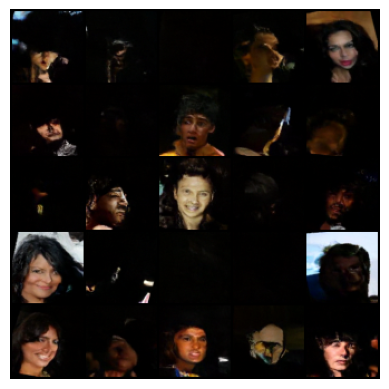

100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [166/450] Loss: 0.0442 LR: 0.000070


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [167/450] Loss: 0.0441 LR: 0.000070


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [168/450] Loss: 0.0438 LR: 0.000070


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [169/450] Loss: 0.0437 LR: 0.000069


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [170/450] Loss: 0.0440 LR: 0.000069


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [171/450] Loss: 0.0438 LR: 0.000069


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [172/450] Loss: 0.0445 LR: 0.000068


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [173/450] Loss: 0.0439 LR: 0.000068


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [174/450] Loss: 0.0439 LR: 0.000068


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [175/450] Loss: 0.0437 LR: 0.000067


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [176/450] Loss: 0.0441 LR: 0.000067


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [177/450] Loss: 0.0439 LR: 0.000067


100%|██████████| 3166/3166 [07:18<00:00,  7.21it/s]


Epoch [178/450] Loss: 0.0439 LR: 0.000066


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [179/450] Loss: 0.0440 LR: 0.000066


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [180/450] Loss: 0.0438 LR: 0.000066


100%|██████████| 16/16 [00:06<00:00,  2.50it/s]


FID at epoch 180: 258.6053

Generated samples at epoch 180:


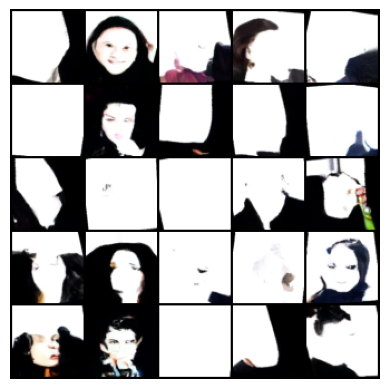

100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [181/450] Loss: 0.0442 LR: 0.000065


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [182/450] Loss: 0.0439 LR: 0.000065


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [183/450] Loss: 0.0437 LR: 0.000065


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [184/450] Loss: 0.0438 LR: 0.000064


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [185/450] Loss: 0.0438 LR: 0.000064


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [186/450] Loss: 0.0440 LR: 0.000064


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [187/450] Loss: 0.0440 LR: 0.000063


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [188/450] Loss: 0.0439 LR: 0.000063


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [189/450] Loss: 0.0439 LR: 0.000063


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [190/450] Loss: 0.0440 LR: 0.000062


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [191/450] Loss: 0.0439 LR: 0.000062


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [192/450] Loss: 0.0441 LR: 0.000062


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [193/450] Loss: 0.0438 LR: 0.000061


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [194/450] Loss: 0.0436 LR: 0.000061


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [195/450] Loss: 0.0438 LR: 0.000061


100%|██████████| 16/16 [00:06<00:00,  2.48it/s]


FID at epoch 195: 97.2847

Generated samples at epoch 195:


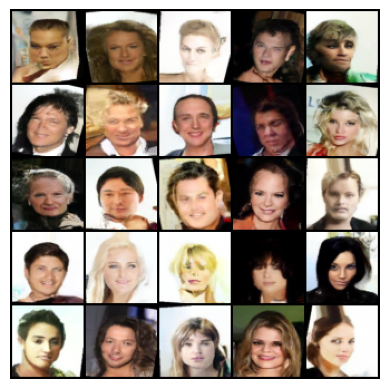

100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [196/450] Loss: 0.0440 LR: 0.000060


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [197/450] Loss: 0.0440 LR: 0.000060


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [198/450] Loss: 0.0437 LR: 0.000060


100%|██████████| 3166/3166 [07:19<00:00,  7.21it/s]


Epoch [199/450] Loss: 0.0438 LR: 0.000059


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [200/450] Loss: 0.0437 LR: 0.000059


100%|██████████| 3166/3166 [07:19<00:00,  7.21it/s]


Epoch [201/450] Loss: 0.0437 LR: 0.000059


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [202/450] Loss: 0.0439 LR: 0.000058


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [203/450] Loss: 0.0439 LR: 0.000058


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [204/450] Loss: 0.0438 LR: 0.000058


100%|██████████| 3166/3166 [07:18<00:00,  7.21it/s]


Epoch [205/450] Loss: 0.0434 LR: 0.000057


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [206/450] Loss: 0.0438 LR: 0.000057


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [207/450] Loss: 0.0436 LR: 0.000057


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [208/450] Loss: 0.0437 LR: 0.000056


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [209/450] Loss: 0.0433 LR: 0.000056


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [210/450] Loss: 0.0440 LR: 0.000056


100%|██████████| 16/16 [00:06<00:00,  2.49it/s]


FID at epoch 210: 144.2888

Generated samples at epoch 210:


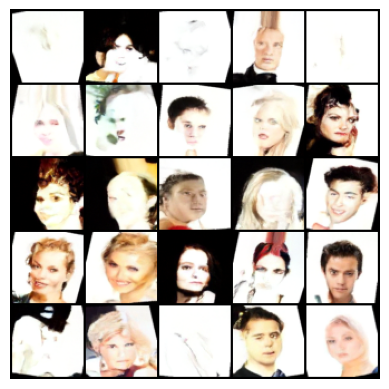

100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [211/450] Loss: 0.0437 LR: 0.000055


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [212/450] Loss: 0.0438 LR: 0.000055


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [213/450] Loss: 0.0437 LR: 0.000055


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [214/450] Loss: 0.0437 LR: 0.000054


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [215/450] Loss: 0.0437 LR: 0.000054


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [216/450] Loss: 0.0438 LR: 0.000054


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [217/450] Loss: 0.0438 LR: 0.000053


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [218/450] Loss: 0.0434 LR: 0.000053


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [219/450] Loss: 0.0437 LR: 0.000053


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [220/450] Loss: 0.0437 LR: 0.000052


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [221/450] Loss: 0.0438 LR: 0.000052


100%|██████████| 3166/3166 [07:18<00:00,  7.21it/s]


Epoch [222/450] Loss: 0.0434 LR: 0.000052


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [223/450] Loss: 0.0438 LR: 0.000051


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [224/450] Loss: 0.0437 LR: 0.000051


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [225/450] Loss: 0.0437 LR: 0.000050


100%|██████████| 16/16 [00:06<00:00,  2.50it/s]


FID at epoch 225: 129.9007

Generated samples at epoch 225:


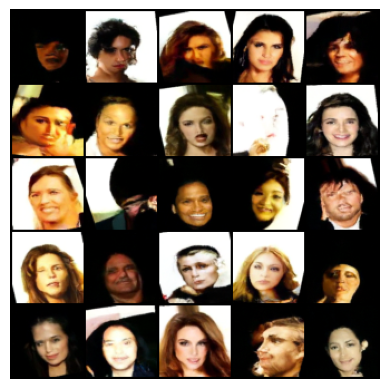

100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [226/450] Loss: 0.0438 LR: 0.000050


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [227/450] Loss: 0.0436 LR: 0.000050


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [228/450] Loss: 0.0435 LR: 0.000049


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [229/450] Loss: 0.0434 LR: 0.000049


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [230/450] Loss: 0.0435 LR: 0.000049


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [231/450] Loss: 0.0435 LR: 0.000048


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [232/450] Loss: 0.0434 LR: 0.000048


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [233/450] Loss: 0.0437 LR: 0.000048


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [234/450] Loss: 0.0433 LR: 0.000047


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [235/450] Loss: 0.0436 LR: 0.000047


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [236/450] Loss: 0.0437 LR: 0.000047


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [237/450] Loss: 0.0435 LR: 0.000046


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [238/450] Loss: 0.0435 LR: 0.000046


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [239/450] Loss: 0.0438 LR: 0.000046


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [240/450] Loss: 0.0438 LR: 0.000045


100%|██████████| 16/16 [00:06<00:00,  2.53it/s]


FID at epoch 240: 180.5319

Generated samples at epoch 240:


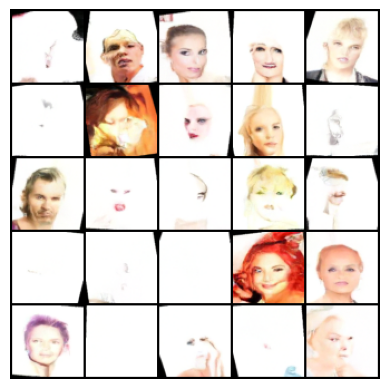

100%|██████████| 3166/3166 [07:16<00:00,  7.25it/s]


Epoch [241/450] Loss: 0.0434 LR: 0.000045


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [242/450] Loss: 0.0434 LR: 0.000045


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [243/450] Loss: 0.0435 LR: 0.000044


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [244/450] Loss: 0.0437 LR: 0.000044


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [245/450] Loss: 0.0435 LR: 0.000044


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [246/450] Loss: 0.0434 LR: 0.000043


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [247/450] Loss: 0.0434 LR: 0.000043


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [248/450] Loss: 0.0437 LR: 0.000043


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [249/450] Loss: 0.0435 LR: 0.000042


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [250/450] Loss: 0.0433 LR: 0.000042


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [251/450] Loss: 0.0435 LR: 0.000042


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [252/450] Loss: 0.0436 LR: 0.000041


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [253/450] Loss: 0.0437 LR: 0.000041


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [254/450] Loss: 0.0435 LR: 0.000041


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [255/450] Loss: 0.0433 LR: 0.000040


100%|██████████| 16/16 [00:06<00:00,  2.47it/s]


FID at epoch 255: 122.4460

Generated samples at epoch 255:


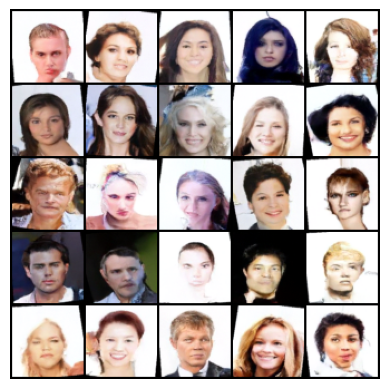

100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [256/450] Loss: 0.0434 LR: 0.000040


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [257/450] Loss: 0.0433 LR: 0.000040


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [258/450] Loss: 0.0436 LR: 0.000039


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [259/450] Loss: 0.0438 LR: 0.000039


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [260/450] Loss: 0.0435 LR: 0.000039


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [261/450] Loss: 0.0437 LR: 0.000038


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [262/450] Loss: 0.0432 LR: 0.000038


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [263/450] Loss: 0.0433 LR: 0.000038


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [264/450] Loss: 0.0435 LR: 0.000037


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [265/450] Loss: 0.0434 LR: 0.000037


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [266/450] Loss: 0.0435 LR: 0.000037


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [267/450] Loss: 0.0434 LR: 0.000036


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [268/450] Loss: 0.0433 LR: 0.000036


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [269/450] Loss: 0.0434 LR: 0.000036


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [270/450] Loss: 0.0436 LR: 0.000035


100%|██████████| 16/16 [00:06<00:00,  2.52it/s]


FID at epoch 270: 111.1074

Generated samples at epoch 270:


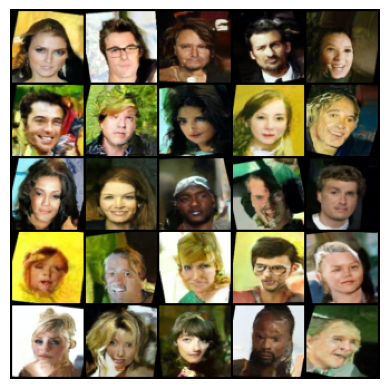

100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [271/450] Loss: 0.0433 LR: 0.000035


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [272/450] Loss: 0.0433 LR: 0.000035


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [273/450] Loss: 0.0435 LR: 0.000034


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [274/450] Loss: 0.0432 LR: 0.000034


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [275/450] Loss: 0.0434 LR: 0.000034


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [276/450] Loss: 0.0437 LR: 0.000033


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [277/450] Loss: 0.0433 LR: 0.000033


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [278/450] Loss: 0.0435 LR: 0.000033


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [279/450] Loss: 0.0434 LR: 0.000032


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [280/450] Loss: 0.0435 LR: 0.000032


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [281/450] Loss: 0.0436 LR: 0.000032


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [282/450] Loss: 0.0435 LR: 0.000031


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [283/450] Loss: 0.0435 LR: 0.000031


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [284/450] Loss: 0.0435 LR: 0.000031


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [285/450] Loss: 0.0435 LR: 0.000030


100%|██████████| 16/16 [00:06<00:00,  2.52it/s]


FID at epoch 285: 136.1943

Generated samples at epoch 285:


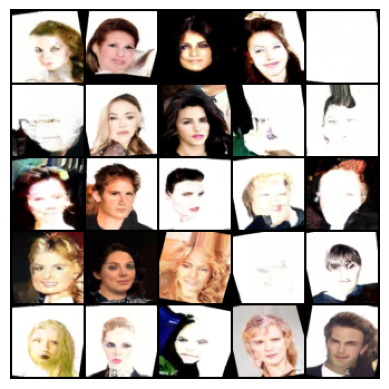

100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [286/450] Loss: 0.0433 LR: 0.000030


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [287/450] Loss: 0.0434 LR: 0.000030


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [288/450] Loss: 0.0435 LR: 0.000029


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [289/450] Loss: 0.0433 LR: 0.000029


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [290/450] Loss: 0.0435 LR: 0.000029


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [291/450] Loss: 0.0434 LR: 0.000028


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [292/450] Loss: 0.0433 LR: 0.000028


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [293/450] Loss: 0.0435 LR: 0.000028


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [294/450] Loss: 0.0433 LR: 0.000028


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [295/450] Loss: 0.0433 LR: 0.000027


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [296/450] Loss: 0.0432 LR: 0.000027


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [297/450] Loss: 0.0434 LR: 0.000027


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [298/450] Loss: 0.0432 LR: 0.000026


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [299/450] Loss: 0.0437 LR: 0.000026


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [300/450] Loss: 0.0432 LR: 0.000026


100%|██████████| 16/16 [00:06<00:00,  2.61it/s]


FID at epoch 300: 164.5707

Generated samples at epoch 300:


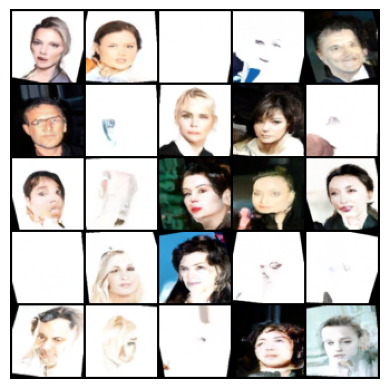

100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [301/450] Loss: 0.0433 LR: 0.000025


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [302/450] Loss: 0.0433 LR: 0.000025


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [303/450] Loss: 0.0432 LR: 0.000025


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [304/450] Loss: 0.0432 LR: 0.000025


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [305/450] Loss: 0.0435 LR: 0.000024


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [306/450] Loss: 0.0431 LR: 0.000024


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [307/450] Loss: 0.0432 LR: 0.000024


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [308/450] Loss: 0.0431 LR: 0.000023


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [309/450] Loss: 0.0431 LR: 0.000023


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [310/450] Loss: 0.0433 LR: 0.000023


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [311/450] Loss: 0.0432 LR: 0.000023


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [312/450] Loss: 0.0433 LR: 0.000022


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [313/450] Loss: 0.0433 LR: 0.000022


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [314/450] Loss: 0.0433 LR: 0.000022


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [315/450] Loss: 0.0434 LR: 0.000021


100%|██████████| 16/16 [00:06<00:00,  2.47it/s]


FID at epoch 315: 116.0774

Generated samples at epoch 315:


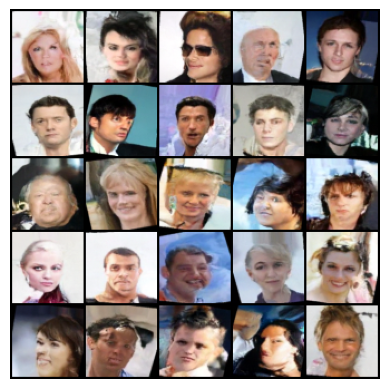

100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [316/450] Loss: 0.0435 LR: 0.000021


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [317/450] Loss: 0.0433 LR: 0.000021


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [318/450] Loss: 0.0434 LR: 0.000021


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [319/450] Loss: 0.0432 LR: 0.000020


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [320/450] Loss: 0.0434 LR: 0.000020


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [321/450] Loss: 0.0430 LR: 0.000020


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [322/450] Loss: 0.0431 LR: 0.000019


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [323/450] Loss: 0.0433 LR: 0.000019


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [324/450] Loss: 0.0431 LR: 0.000019


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [325/450] Loss: 0.0431 LR: 0.000019


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [326/450] Loss: 0.0431 LR: 0.000018


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [327/450] Loss: 0.0434 LR: 0.000018


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [328/450] Loss: 0.0432 LR: 0.000018


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [329/450] Loss: 0.0434 LR: 0.000018


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [330/450] Loss: 0.0432 LR: 0.000017


100%|██████████| 16/16 [00:06<00:00,  2.48it/s]


FID at epoch 330: 166.9991

Generated samples at epoch 330:


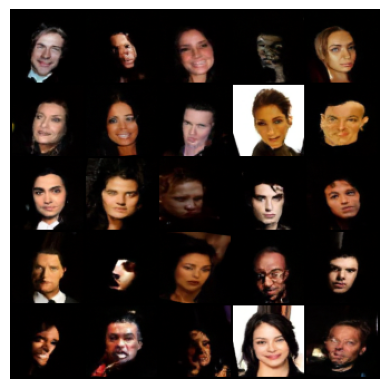

100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [331/450] Loss: 0.0431 LR: 0.000017


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [332/450] Loss: 0.0433 LR: 0.000017


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [333/450] Loss: 0.0431 LR: 0.000017


100%|██████████| 3166/3166 [07:18<00:00,  7.21it/s]


Epoch [334/450] Loss: 0.0432 LR: 0.000016


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [335/450] Loss: 0.0432 LR: 0.000016


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [336/450] Loss: 0.0433 LR: 0.000016


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [337/450] Loss: 0.0431 LR: 0.000016


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [338/450] Loss: 0.0433 LR: 0.000015


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [339/450] Loss: 0.0431 LR: 0.000015


100%|██████████| 3166/3166 [07:18<00:00,  7.21it/s]


Epoch [340/450] Loss: 0.0431 LR: 0.000015


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [341/450] Loss: 0.0434 LR: 0.000015


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [342/450] Loss: 0.0432 LR: 0.000014


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [343/450] Loss: 0.0432 LR: 0.000014


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [344/450] Loss: 0.0432 LR: 0.000014


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [345/450] Loss: 0.0434 LR: 0.000014


100%|██████████| 16/16 [00:06<00:00,  2.47it/s]


FID at epoch 345: 193.7169

Generated samples at epoch 345:


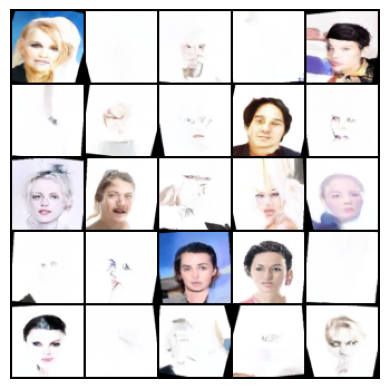

100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [346/450] Loss: 0.0431 LR: 0.000013


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [347/450] Loss: 0.0433 LR: 0.000013


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [348/450] Loss: 0.0433 LR: 0.000013


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [349/450] Loss: 0.0432 LR: 0.000013


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [350/450] Loss: 0.0434 LR: 0.000013


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [351/450] Loss: 0.0430 LR: 0.000012


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [352/450] Loss: 0.0435 LR: 0.000012


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [353/450] Loss: 0.0432 LR: 0.000012


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [354/450] Loss: 0.0432 LR: 0.000012


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [355/450] Loss: 0.0432 LR: 0.000011


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [356/450] Loss: 0.0430 LR: 0.000011


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [357/450] Loss: 0.0432 LR: 0.000011


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [358/450] Loss: 0.0432 LR: 0.000011


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [359/450] Loss: 0.0433 LR: 0.000011


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [360/450] Loss: 0.0430 LR: 0.000010


100%|██████████| 16/16 [00:06<00:00,  2.49it/s]


FID at epoch 360: 133.5556

Generated samples at epoch 360:


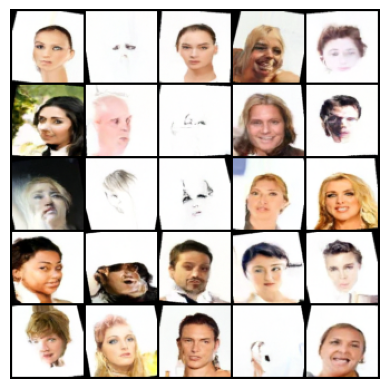

100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [361/450] Loss: 0.0434 LR: 0.000010


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [362/450] Loss: 0.0432 LR: 0.000010


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [363/450] Loss: 0.0433 LR: 0.000010


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [364/450] Loss: 0.0430 LR: 0.000010


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [365/450] Loss: 0.0428 LR: 0.000009


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [366/450] Loss: 0.0432 LR: 0.000009


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [367/450] Loss: 0.0433 LR: 0.000009


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [368/450] Loss: 0.0432 LR: 0.000009


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [369/450] Loss: 0.0431 LR: 0.000009


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [370/450] Loss: 0.0430 LR: 0.000009


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [371/450] Loss: 0.0430 LR: 0.000008


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [372/450] Loss: 0.0431 LR: 0.000008


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [373/450] Loss: 0.0430 LR: 0.000008


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [374/450] Loss: 0.0429 LR: 0.000008


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [375/450] Loss: 0.0432 LR: 0.000008


100%|██████████| 16/16 [00:06<00:00,  2.47it/s]


FID at epoch 375: 106.6608

Generated samples at epoch 375:


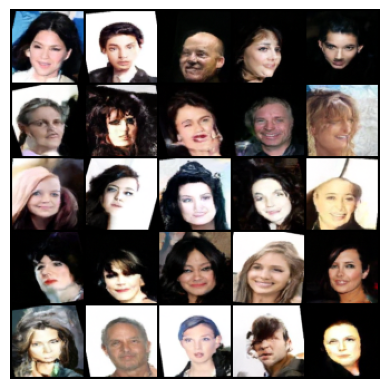

100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [376/450] Loss: 0.0431 LR: 0.000007


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [377/450] Loss: 0.0432 LR: 0.000007


100%|██████████| 3166/3166 [07:18<00:00,  7.21it/s]


Epoch [378/450] Loss: 0.0428 LR: 0.000007


100%|██████████| 3166/3166 [07:19<00:00,  7.21it/s]


Epoch [379/450] Loss: 0.0431 LR: 0.000007


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [380/450] Loss: 0.0433 LR: 0.000007


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [381/450] Loss: 0.0432 LR: 0.000007


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [382/450] Loss: 0.0433 LR: 0.000006


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [383/450] Loss: 0.0431 LR: 0.000006


100%|██████████| 3166/3166 [07:29<00:00,  7.04it/s]


Epoch [384/450] Loss: 0.0429 LR: 0.000006


100%|██████████| 3166/3166 [07:38<00:00,  6.91it/s]


Epoch [385/450] Loss: 0.0431 LR: 0.000006


100%|██████████| 3166/3166 [07:32<00:00,  6.99it/s]


Epoch [386/450] Loss: 0.0431 LR: 0.000006


100%|██████████| 3166/3166 [07:22<00:00,  7.15it/s]


Epoch [387/450] Loss: 0.0432 LR: 0.000006


100%|██████████| 3166/3166 [07:23<00:00,  7.14it/s]


Epoch [388/450] Loss: 0.0429 LR: 0.000006


100%|██████████| 3166/3166 [07:30<00:00,  7.03it/s]


Epoch [389/450] Loss: 0.0432 LR: 0.000005


100%|██████████| 3166/3166 [07:36<00:00,  6.93it/s]


Epoch [390/450] Loss: 0.0432 LR: 0.000005


100%|██████████| 16/16 [00:07<00:00,  2.27it/s]


FID at epoch 390: 115.5895

Generated samples at epoch 390:


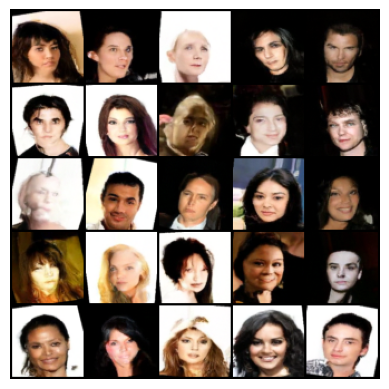

100%|██████████| 3166/3166 [07:44<00:00,  6.82it/s]


Epoch [391/450] Loss: 0.0434 LR: 0.000005


100%|██████████| 3166/3166 [07:37<00:00,  6.92it/s]


Epoch [392/450] Loss: 0.0431 LR: 0.000005


100%|██████████| 3166/3166 [07:32<00:00,  6.99it/s]


Epoch [393/450] Loss: 0.0430 LR: 0.000005


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [394/450] Loss: 0.0431 LR: 0.000005


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [395/450] Loss: 0.0430 LR: 0.000005


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [396/450] Loss: 0.0432 LR: 0.000004


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [397/450] Loss: 0.0430 LR: 0.000004


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [398/450] Loss: 0.0432 LR: 0.000004


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [399/450] Loss: 0.0430 LR: 0.000004


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [400/450] Loss: 0.0431 LR: 0.000004


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [401/450] Loss: 0.0431 LR: 0.000004


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [402/450] Loss: 0.0432 LR: 0.000004


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [403/450] Loss: 0.0429 LR: 0.000004


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [404/450] Loss: 0.0429 LR: 0.000004


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [405/450] Loss: 0.0429 LR: 0.000003


100%|██████████| 16/16 [00:06<00:00,  2.50it/s]


FID at epoch 405: 121.5412

Generated samples at epoch 405:


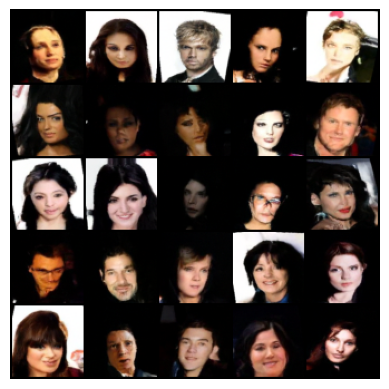

100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [406/450] Loss: 0.0434 LR: 0.000003


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [407/450] Loss: 0.0432 LR: 0.000003


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [408/450] Loss: 0.0430 LR: 0.000003


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [409/450] Loss: 0.0431 LR: 0.000003


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [410/450] Loss: 0.0433 LR: 0.000003


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [411/450] Loss: 0.0430 LR: 0.000003


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [412/450] Loss: 0.0429 LR: 0.000003


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [413/450] Loss: 0.0432 LR: 0.000003


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [414/450] Loss: 0.0432 LR: 0.000003


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [415/450] Loss: 0.0430 LR: 0.000002


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [416/450] Loss: 0.0431 LR: 0.000002


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [417/450] Loss: 0.0430 LR: 0.000002


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [418/450] Loss: 0.0429 LR: 0.000002


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [419/450] Loss: 0.0431 LR: 0.000002


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [420/450] Loss: 0.0430 LR: 0.000002


100%|██████████| 16/16 [00:06<00:00,  2.51it/s]


FID at epoch 420: 98.2464

Generated samples at epoch 420:


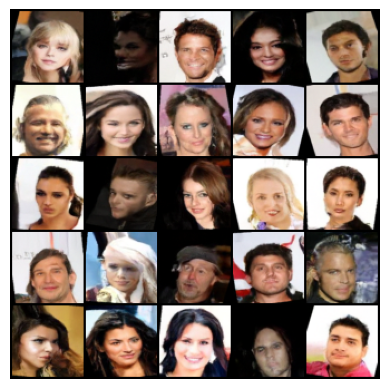

100%|██████████| 3166/3166 [07:16<00:00,  7.25it/s]


Epoch [421/450] Loss: 0.0431 LR: 0.000002


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [422/450] Loss: 0.0431 LR: 0.000002


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [423/450] Loss: 0.0430 LR: 0.000002


100%|██████████| 3166/3166 [07:20<00:00,  7.19it/s]


Epoch [424/450] Loss: 0.0428 LR: 0.000002


100%|██████████| 3166/3166 [07:19<00:00,  7.20it/s]


Epoch [425/450] Loss: 0.0431 LR: 0.000002


100%|██████████| 3166/3166 [07:20<00:00,  7.19it/s]


Epoch [426/450] Loss: 0.0432 LR: 0.000002


100%|██████████| 3166/3166 [07:20<00:00,  7.19it/s]


Epoch [427/450] Loss: 0.0431 LR: 0.000002


100%|██████████| 3166/3166 [07:19<00:00,  7.20it/s]


Epoch [428/450] Loss: 0.0431 LR: 0.000002


100%|██████████| 3166/3166 [07:20<00:00,  7.19it/s]


Epoch [429/450] Loss: 0.0428 LR: 0.000002


100%|██████████| 3166/3166 [07:19<00:00,  7.20it/s]


Epoch [430/450] Loss: 0.0432 LR: 0.000001


100%|██████████| 3166/3166 [07:19<00:00,  7.20it/s]


Epoch [431/450] Loss: 0.0431 LR: 0.000001


100%|██████████| 3166/3166 [07:18<00:00,  7.21it/s]


Epoch [432/450] Loss: 0.0428 LR: 0.000001


100%|██████████| 3166/3166 [07:20<00:00,  7.19it/s]


Epoch [433/450] Loss: 0.0432 LR: 0.000001


100%|██████████| 3166/3166 [07:19<00:00,  7.21it/s]


Epoch [434/450] Loss: 0.0430 LR: 0.000001


100%|██████████| 3166/3166 [07:19<00:00,  7.21it/s]


Epoch [435/450] Loss: 0.0429 LR: 0.000001


100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


FID at epoch 435: 116.0813

Generated samples at epoch 435:


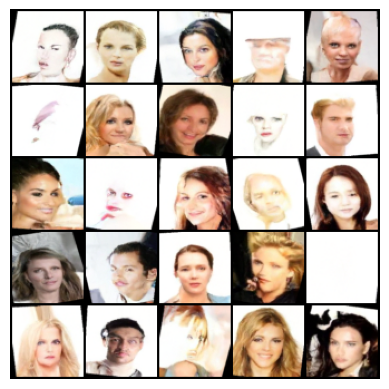

100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [436/450] Loss: 0.0431 LR: 0.000001


100%|██████████| 3166/3166 [07:19<00:00,  7.21it/s]


Epoch [437/450] Loss: 0.0429 LR: 0.000001


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [438/450] Loss: 0.0431 LR: 0.000001


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [439/450] Loss: 0.0431 LR: 0.000001


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [440/450] Loss: 0.0429 LR: 0.000001


100%|██████████| 3166/3166 [07:18<00:00,  7.22it/s]


Epoch [441/450] Loss: 0.0430 LR: 0.000001


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [442/450] Loss: 0.0428 LR: 0.000001


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [443/450] Loss: 0.0428 LR: 0.000001


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [444/450] Loss: 0.0433 LR: 0.000001


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [445/450] Loss: 0.0431 LR: 0.000001


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [446/450] Loss: 0.0429 LR: 0.000001


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [447/450] Loss: 0.0430 LR: 0.000001


100%|██████████| 3166/3166 [07:17<00:00,  7.23it/s]


Epoch [448/450] Loss: 0.0431 LR: 0.000001


100%|██████████| 3166/3166 [07:17<00:00,  7.24it/s]


Epoch [449/450] Loss: 0.0430 LR: 0.000001


100%|██████████| 3166/3166 [07:18<00:00,  7.23it/s]


Epoch [450/450] Loss: 0.0431 LR: 0.000001


100%|██████████| 16/16 [00:06<00:00,  2.45it/s]


FID at epoch 450: 100.5256

Generated samples at epoch 450:


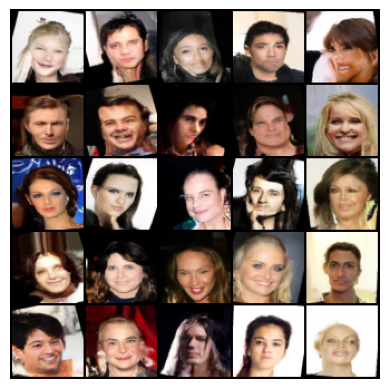


Final generated samples:


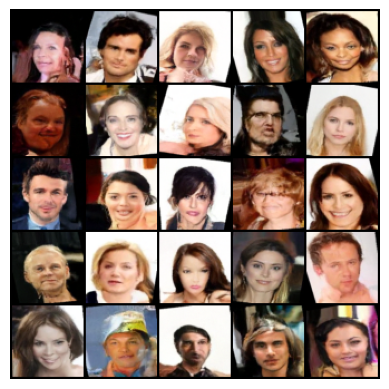

In [36]:
# Initialize model and diffusion

model = UNet().to(device)
diffusion = Diffusion(T)
optimizer = optim.AdamW(model.parameters(), lr=LR)  # Using AdamW optimizer

# # Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

# Function to display tensor images
def show_tensor_images(image_tensor, num_images=25, nrow=5, size=(64, 64, 3)):

    # Convert from [-1,1] to [0,1]
    image_tensor = (image_tensor + 1) / 2
    
    # Convert to numpy and permute dimensions
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.axis('off')
    plt.show()

# Training loop
losses = []
fid_scores = []

for epoch in range(EPOCHS):
    epoch_loss = 0
    model.train()

    for batch_idx, (real_images, _) in enumerate(tqdm(dataloader)):
        real_images = real_images.to(device)
        
        # Sample random timesteps
        t = diffusion.sample_timesteps(real_images.size(0))
        
        # Forward process (add noise)
        noisy_images, noise = diffusion.forward_process(real_images, t)
        
        # Predict noise
        predicted_noise = model(noisy_images, t)
        
        # Calculate loss
        loss = F.mse_loss(predicted_noise, noise) + 0.1 * F.l1_loss(predicted_noise, noise)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    # Step the learning rate scheduler
    scheduler.step()
    
    # Log average loss for the epoch
    avg_loss = epoch_loss / len(dataloader)
    losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{EPOCHS}] Loss: {avg_loss:.4f} LR: {scheduler.get_last_lr()[0]:.6f}")
    
    # Calculate FID every 15 epochs
    if (epoch + 1) % 15 == 0 or epoch == EPOCHS - 1:
        model.eval()
        
        # Generate fake images
        fake_images = diffusion.reverse_process(model, n=1000, img_size=IMG_SIZE)
        
        # Select a batch of real images
        real_images, _ = next(iter(dataloader))
        real_images = real_images[:1000].to(device)
        
        # Calculate FID
        fid_value = calculate_fid(real_images, fake_images)
        fid_scores.append(fid_value)
        print(f"FID at epoch {epoch+1}: {fid_value:.4f}")
        
        # Display samples
        print(f"\nGenerated samples at epoch {epoch+1}:")
        show_tensor_images(fake_images[:25], num_images=25, nrow=5)
        
        # Plot losses and FID scores
        plt.figure(figsize=(10, 5))
        plt.plot(losses, label="Training Loss")
        plt.plot(range(15, len(fid_scores) * 15 + 1, 15), fid_scores, label="FID Score", marker='o')
        plt.title("Training Loss and FID Score")
        plt.xlabel("Epoch")
        plt.ylabel("Value")
        plt.legend()
        plt.savefig("training_loss_and_fid.png")
        plt.close()
 
# Generate and save final samples
model.eval()
final_samples = diffusion.reverse_process(model, n=25, img_size=IMG_SIZE)

# Display final samples
print("\nFinal generated samples:")
show_tensor_images(final_samples, num_images=25, nrow=5)


C:\Users\vgor\AppData\Local\Temp\ipykernel_12688\778399184.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))



Newly generated samples from ddpm_model.pth:


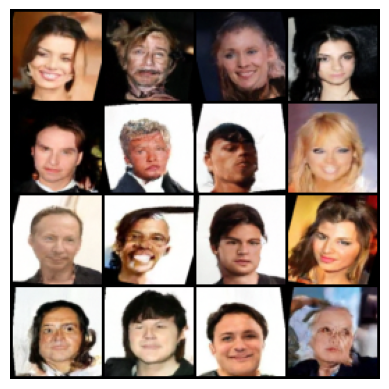

In [39]:
# model = UNet().to(device)
# diffusion = Diffusion(T)
# Save model
torch.save(model.state_dict(), "ddpm_model.pth")



# Function to load and generate new images
def load_and_generate(model_path, num_images=16, nrow=4):
    """Load saved model and generate new images"""
    # Load model
    model = UNet().to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    # Generate new samples
    with torch.no_grad():
        new_samples = diffusion.reverse_process(model, num_images, IMG_SIZE)
        
        # Display samples
        print(f"\nNewly generated samples from {model_path}:")
        show_tensor_images(new_samples, num_images=num_images, nrow=nrow)
        
        # Save samples
        save_image((new_samples + 1) / 2, "new_samples.png", nrow=nrow)
        return new_samples

# Example usage to load and generate new images
new_samples = load_and_generate("ddpm_model.pth", num_images=16, nrow=4)

In [40]:
# Calculate FID score for new samples
real_images, _ = next(iter(dataloader))     
fid_value = calculate_fid(real_images[:10000], new_samples[:10000])
print(f"\nFID Score for new samples: {fid_value:.4f}")

100%|██████████| 1/1 [00:03<00:00,  3.02s/it]


100%|██████████| 1/1 [00:02<00:00,  2.90s/it]



FID Score for new samples: 149.3640
